In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import seaborn as sns
pd.set_option('display.max_rows', None)


In [2]:
os.getcwd()

'C:\\Users\\User\\Documents\\GitHub\\Hypertension_prediction\\Hypertension(regularly sampled data)\\Codebase(previous paper codes)\\Hypertension_code_amy'

In [77]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [4]:
#!git clone https://github.com/caow13/BRITS.git

In [5]:
#from sklearn.impute import KNNImputer
#p10049_knn_imputed = p10049.copy(deep=True)
#knn_imp = KNNImputer(n_neighbors=3)
#p10049_knn_imputed.loc[:, :] = knn_imp.fit_transform(p10049_knn_imputed)


In [6]:
#from sklearn.datasets import make_friedman2
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
#X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel,
#        random_state=0).fit(X, y)
#gpr.score(X, y)

#gpr.predict(X[:2,:], return_std=True)


first create patient train test set

In [80]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [81]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [46]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [47]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=2)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=2)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


KNN Inputation

In [48]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [49]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

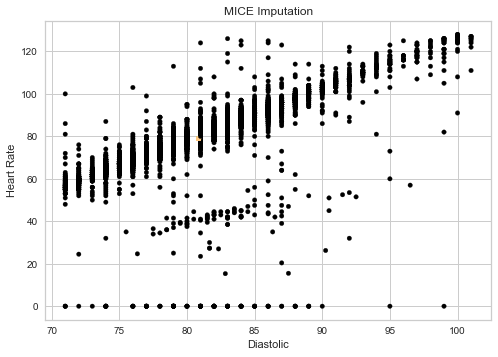

In [50]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_mice_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='MICE Imputation', colorbar=False)
#https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87#:~:text=Time%20Series%20Imputation&text=One%20way%20to%20impute%20missing,with%20the%20previously%20observed%20value

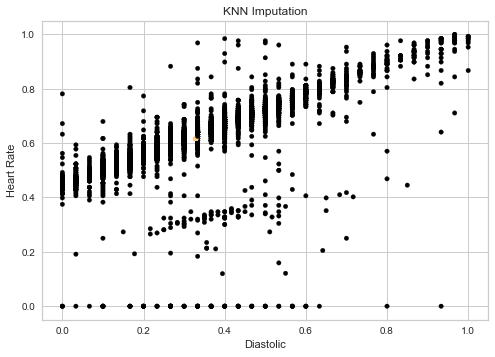

In [51]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_knn_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='KNN Imputation', colorbar=False)


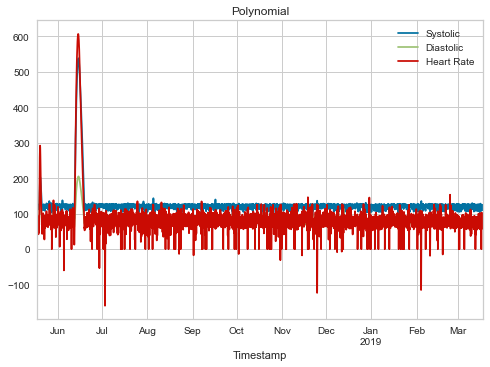

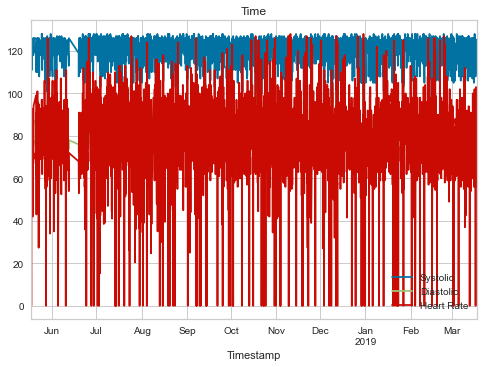

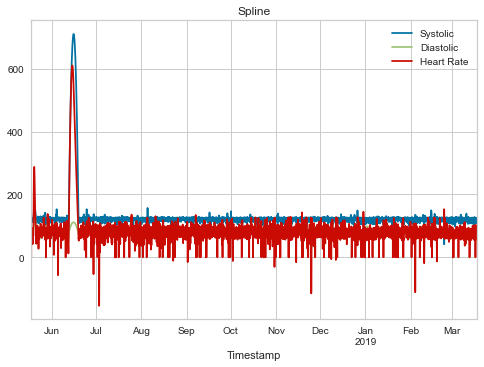

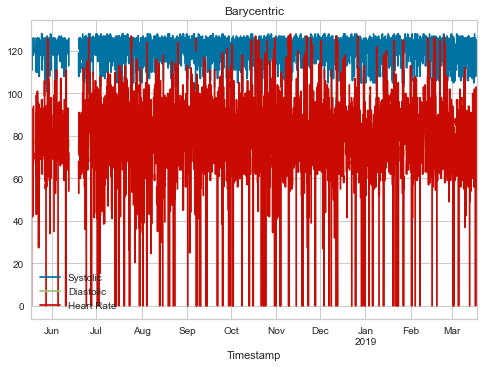

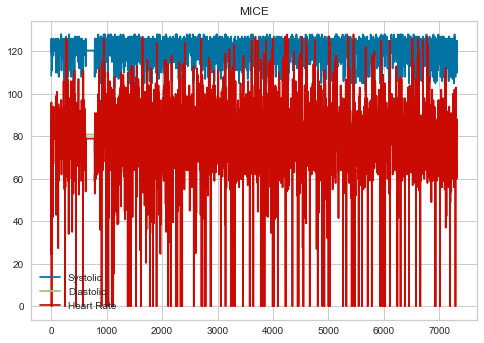

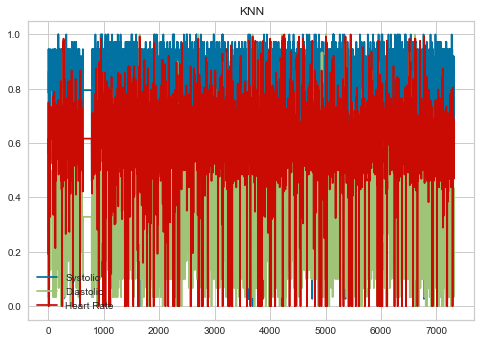

In [82]:
figsize=(40,15)
df_poly_imputed.plot(title='Polynomial')
df_time_imputed.plot(title='Time')
df_spline_imputed.plot(title='Spline')
df_barycentric_imputed.plot(title='Barycentric')
df_mice_imputed.plot(title='MICE')
df_knn_imputed.plot(title='KNN')
lines, labels = plt.gca().get_legend_handles_labels()
#labels = ['linear', 'time' ,'spline','barycentric']
plt.legend(lines, labels, loc='best')

In [ ]:
#df_mice_imputed_train,df_mice_imputed_test= np.split(df_mice_imputed, [int(.7 *len(df_mice_imputed))])


In [53]:
from pycaret.anomaly import *
s = setup(df_mice_imputed, use_gpu=True,session_id=123)


In [54]:
iforest = create_model('iforest')
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


In [55]:
svm = create_model('svm')
print(svm)

OCSVM(cache_size=200, coef0=0.0, contamination=0.05, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)


In [56]:
knn= create_model('knn')
print(knn)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)


In [ ]:
#models()


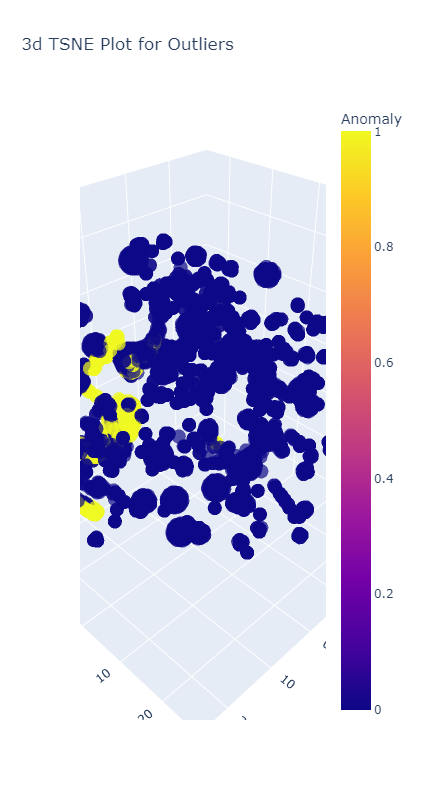

In [57]:
plot_model(iforest, plot = 'tsne')

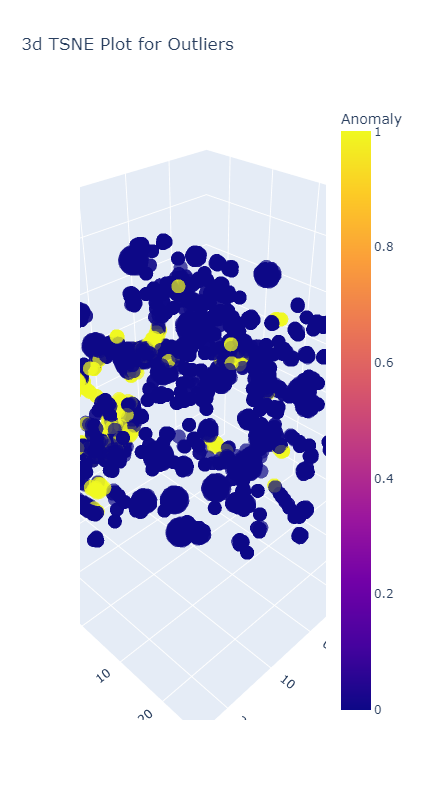

In [25]:
plot_model(svm, plot = 'tsne')

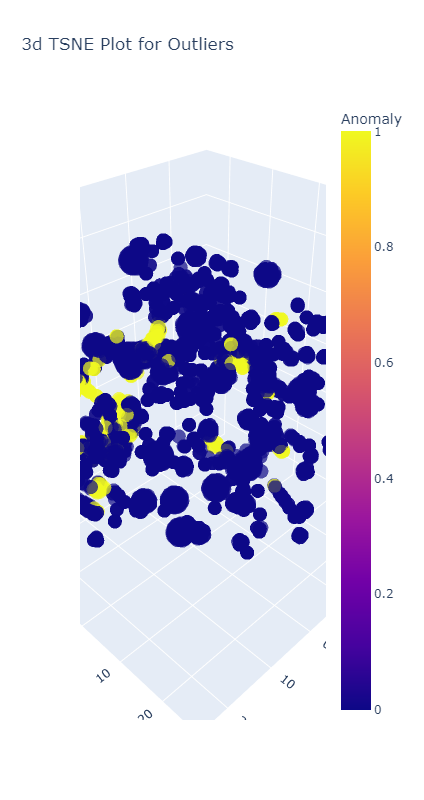

In [58]:
plot_model(knn, plot = 'tsne')

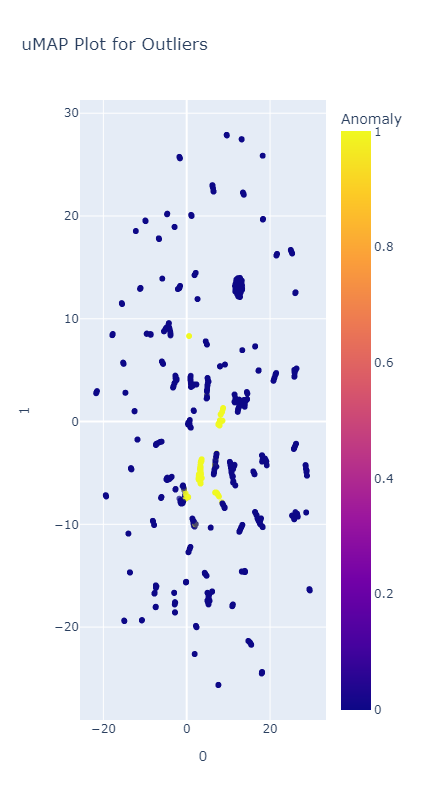

In [59]:
plot_model(iforest, plot = 'umap')

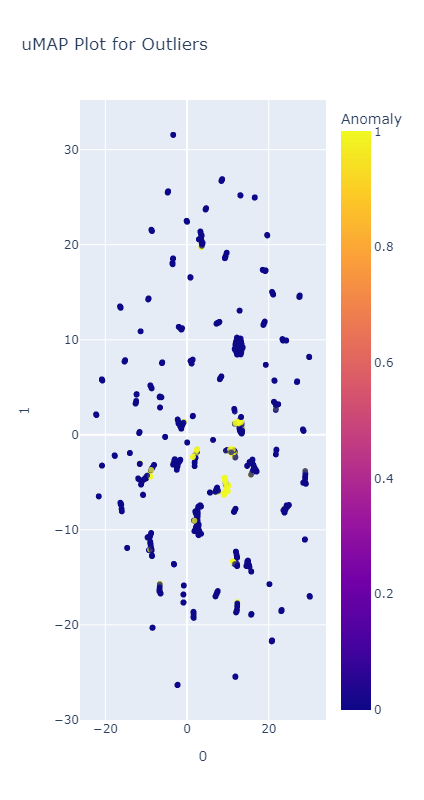

In [60]:
plot_model(svm, plot = 'umap')

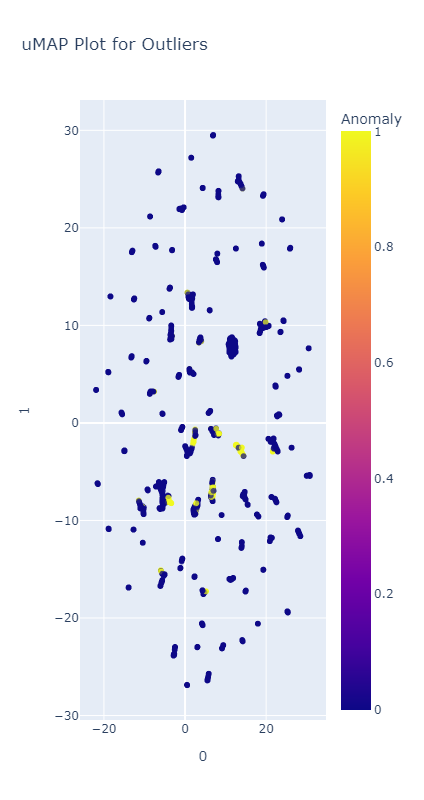

In [61]:
plot_model(knn, plot = 'umap')

In [62]:
iforest_result = assign_model(iforest)
iforest_result

Systolic  Diastolic  Heart Rate  Anomaly  Anomaly_Score
0        108.5       72.0        24.5        1       0.054006
1        119.0       76.0        53.0        0      -0.072589
2        123.0       81.0        82.0        0      -0.225320
3        126.0       87.0        96.0        0      -0.131296
4        121.5       80.0        40.0        0      -0.027578
...        ...        ...         ...      ...            ...
7317     120.0       83.0        88.0        0      -0.210495
7318     123.0       81.0        80.0        0      -0.223956
7319     121.0       83.0        88.0        0      -0.214854
7320     122.0       84.0        88.0        0      -0.215950
7321     123.0       80.0        79.0        0      -0.211783

[7322 rows x 5 columns]

In [63]:
knn_result = assign_model(knn)
knn_result

Systolic  Diastolic  Heart Rate  Anomaly  Anomaly_Score
0        108.5       72.0        24.5        1      15.604487
1        119.0       76.0        53.0        1       3.741657
2        123.0       81.0        82.0        0       0.000000
3        126.0       87.0        96.0        0       0.000000
4        121.5       80.0        40.0        0       1.500000
...        ...        ...         ...      ...            ...
7317     120.0       83.0        88.0        0       0.000000
7318     123.0       81.0        80.0        0       0.000000
7319     121.0       83.0        88.0        0       0.000000
7320     122.0       84.0        88.0        0       0.000000
7321     123.0       80.0        79.0        0       0.000000

[7322 rows x 5 columns]

In [64]:
svm_result = assign_model(svm)
svm_result

Systolic  Diastolic  Heart Rate  Anomaly  Anomaly_Score
0        108.5       72.0        24.5        1      68.161360
1        119.0       76.0        53.0        1      67.903514
2        123.0       81.0        82.0        0      -1.393994
3        126.0       87.0        96.0        0      -0.000552
4        121.5       80.0        40.0        0      62.630146
...        ...        ...         ...      ...            ...
7317     120.0       83.0        88.0        0       1.850624
7318     123.0       81.0        80.0        0       0.000174
7319     121.0       83.0        88.0        0       0.000182
7320     122.0       84.0        88.0        0      -3.003227
7321     123.0       80.0        79.0        0      -1.045057

[7322 rows x 5 columns]

In [65]:
iforest_anomaly=iforest_result[iforest_result['Anomaly']==1]
iforest_anomaly.shape

(367, 5)

In [66]:
knn_anomaly=knn_result[knn_result['Anomaly']==1]
knn_anomaly.shape

(316, 5)

In [67]:
svm_anomaly=svm_result[svm_result['Anomaly']==1]
svm_anomaly.shape

(367, 5)

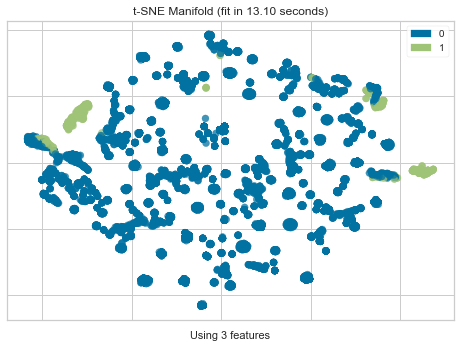

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 13.10 seconds)'}, xlabel='Using 3 features'>

In [68]:
from yellowbrick.features import Manifold
dfr = iforest_result['Anomaly']
viz = Manifold(manifold="tsne")
viz.fit_transform(df_mice_imputed, dfr)
viz.show()

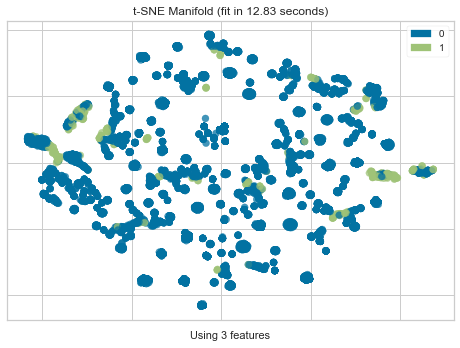

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 12.83 seconds)'}, xlabel='Using 3 features'>

In [69]:
from yellowbrick.features import Manifold
dfr = knn_result['Anomaly']
viz = Manifold(manifold="tsne")
viz.fit_transform(df_mice_imputed, dfr)
viz.show()

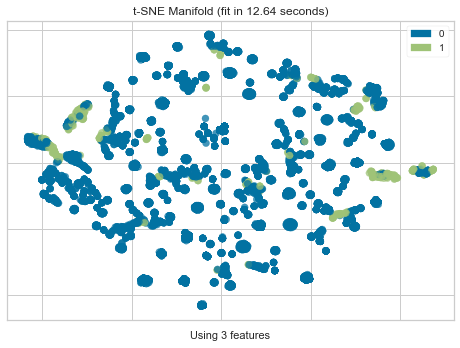

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 12.64 seconds)'}, xlabel='Using 3 features'>

In [73]:
from yellowbrick.features import Manifold
dfr = svm_result['Anomaly']
viz = Manifold(manifold="tsne")
viz.fit_transform(df_mice_imputed, dfr)
viz.show()

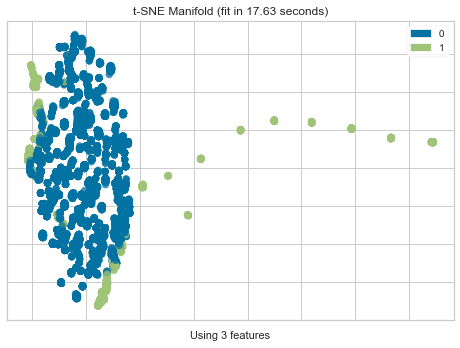

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 17.63 seconds)'}, xlabel='Using 3 features'>

In [74]:
predictions = predict_model(iforest, data = df_poly_imputed)
predictions
from yellowbrick.features import Manifold
dfr = predictions['Anomaly']
viz = Manifold(manifold="tsne")
viz.fit_transform(df_poly_imputed, dfr)
viz.show()

In [75]:
save_model(iforest, 'iforest_pipeline')
loaded_model = load_model('iforest_pipeline')
print(loaded_model)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                ('fix_perfect', 'passthrough'),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'pass